In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import seaborn as sns

In [40]:
# Select necessary columns and limit to the first 45,000 rows for each dataset
folder_path = "/Users/qinhan/Downloads/mimic-iii-clinical-database-1.4"
admissions = pd.read_csv(
    f'{folder_path}/ADMISSIONS.csv',
    usecols=['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'HOSPITAL_EXPIRE_FLAG'],
    nrows=45000
)

patients = pd.read_csv(
    f'{folder_path}/PATIENTS.csv',
    usecols=['SUBJECT_ID', 'GENDER', 'DOB'],
    nrows=45000
)

icustays = pd.read_csv(
    f'{folder_path}/ICUSTAYS.csv',
    usecols=['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME'],
    nrows=45000
)

prescriptions = pd.read_csv(
    f'{folder_path}/PRESCRIPTIONS.csv',
    usecols=['HADM_ID', 'DRUG', 'STARTDATE', 'ENDDATE'],
    nrows=45000
)

chartevents = pd.read_csv(
    f'{folder_path}/CHARTEVENTS.csv',
    usecols=['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUENUM', 'CHARTTIME'],
    nrows=45000
)

labevents = pd.read_csv(
    f'{folder_path}/LABEVENTS.csv',
    usecols=['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUENUM', 'CHARTTIME'],
    nrows=45000
)

outputevents = pd.read_csv(
    f'{folder_path}/OUTPUTEVENTS.csv',
    usecols=['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUE', 'CHARTTIME'],
    nrows=45000
)

print("ADMISSIONS:", admissions.shape)
print("PATIENTS:", patients.shape)
print("ICUSTAYS:", icustays.shape)
print("PRESCRIPTIONS:", prescriptions.shape)
print("CHARTEVENTS:", chartevents.shape)
print("LABEVENTS:", labevents.shape)
print("OUTPUTEVENTS:", outputevents.shape)


ADMISSIONS: (45000, 5)
PATIENTS: (45000, 3)
ICUSTAYS: (45000, 5)
PRESCRIPTIONS: (45000, 4)
CHARTEVENTS: (45000, 5)
LABEVENTS: (45000, 5)
OUTPUTEVENTS: (45000, 5)


In [41]:
# Keywords to search
search_keyword = "blood pressure"
d_items = pd.read_csv('/Users/qinhan/Downloads/mimic-iii-clinical-database-1.4/D_ITEMS.csv', usecols=['ITEMID', 'LABEL'])
filtered_items = d_items[d_items['LABEL'].str.contains(search_keyword, case=False, na=False)]
print(filtered_items)

       ITEMID                                     LABEL
9314   224167       Manual Blood Pressure Systolic Left
9441   227242     Manual Blood Pressure Diastolic Right
9442   227243      Manual Blood Pressure Systolic Right
9578   223751  Non-Invasive Blood Pressure Alarm - High
10261  227537           ART Blood Pressure Alarm - High
10262  227538            ART Blood Pressure Alarm - Low
10263  227539           ART Blood Pressure Alarm Source
11323  224643      Manual Blood Pressure Diastolic Left
11502  220050          Arterial Blood Pressure systolic
11503  220051         Arterial Blood Pressure diastolic
11504  220052              Arterial Blood Pressure mean
11505  220056       Arterial Blood Pressure Alarm - Low
11506  220058      Arterial Blood Pressure Alarm - High
11520  220179      Non Invasive Blood Pressure systolic
11521  220180     Non Invasive Blood Pressure diastolic
11522  220181          Non Invasive Blood Pressure mean
12360  223752   Non-Invasive Blood Pressure Alar

In [42]:
# Combine datasets
# Step 1: Convert datetimes
admissions['ADMITTIME'] = pd.to_datetime(admissions['ADMITTIME'])
admissions['DISCHTIME'] = pd.to_datetime(admissions['DISCHTIME'])
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])
prescriptions['STARTDATE'] = pd.to_datetime(prescriptions['STARTDATE'])
prescriptions['ENDDATE'] = pd.to_datetime(prescriptions['ENDDATE'])
chartevents['CHARTTIME'] = pd.to_datetime(chartevents['CHARTTIME'])

# # Step 2: Filter ICU patients
# icu_admissions = admissions[admissions['HADM_ID'].isin(icustays['HADM_ID'])]

# # Step 3: Define treatment (Vasopress)
# treatment_drug = 'Vasopress'  # Replace with the actual drug name
# treated_patients = prescriptions[prescriptions['DRUG'].str.contains(treatment_drug, na=False, case=False)]

# # Step 4: Define outcome (Mortality)
# icu_admissions = icu_admissions.merge(icustays[['HADM_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME']], on='HADM_ID', how='inner')

# # Step 5: Define confounder (Blood Pressure)
# confounder_itemid = 220050
# confounders = chartevents[chartevents['ITEMID'] == confounder_itemid]

# # Step 6: Merge treatment and confounders with ICU stays
# # Merge treatment
# merged_data = icu_admissions.merge(treated_patients[['HADM_ID', 'STARTDATE', 'ENDDATE']], on='HADM_ID', how='left')
# # Merge confounder
# merged_data = merged_data.merge(confounders[['HADM_ID', 'CHARTTIME', 'VALUENUM']], on='HADM_ID', how='left')

# # Step 7: Restrict to ICU period
# merged_data = merged_data[
#     (merged_data['CHARTTIME'] >= merged_data['INTIME']) &
#     (merged_data['CHARTTIME'] <= merged_data['OUTTIME'])
# ]

# # Rename columns
# merged_data.rename(columns={
#     'VALUENUM': 'Systolic_Blood_Pressure',
#     'HOSPITAL_EXPIRE_FLAG': 'Mortality',
#     'STARTDATE': 'Treatment_Start',
#     'ENDDATE': 'Treatment_End'
# }, inplace=True)

# # Display the first few rows
# print(merged_data.head())

# # Save the processed data for later analysis
# merged_data.to_csv('processed_mimic_data.csv', index=False)


In [43]:
# Initialize an empty DataFrame to store results
filtered_chartevents = pd.DataFrame()

# Use chunks to process CHARTEVENTS
chunk_size = 50000
for chunk in pd.read_csv('/Users/qinhan/Downloads/mimic-iii-clinical-database-1.4/CHARTEVENTS.csv', usecols=['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUENUM', 'CHARTTIME'], chunksize=chunk_size):
    # Filter for systolic blood pressure (220050)
    chunk_filtered = chunk[chunk['ITEMID'] == 220050]
    filtered_chartevents = pd.concat([filtered_chartevents, chunk_filtered], ignore_index=True)

# Convert CHARTTIME to datetime
filtered_chartevents['CHARTTIME'] = pd.to_datetime(filtered_chartevents['CHARTTIME'])

# Save the filtered data for later use
filtered_chartevents.to_csv('systolic_blood_pressure.csv', index=False)

# Display the first few rows
print(filtered_chartevents.head())

   SUBJECT_ID  HADM_ID  ITEMID           CHARTTIME  VALUENUM
0          23   124321  220050 2157-10-22 11:00:00     128.0
1          23   124321  220050 2157-10-22 12:00:00     144.0
2          23   124321  220050 2157-10-22 13:00:00     118.0
3          23   124321  220050 2157-10-22 14:00:00     124.0
4          23   124321  220050 2157-10-22 15:00:00     135.0


In [44]:
systolic_bp = pd.read_csv('systolic_blood_pressure.csv', parse_dates=['CHARTTIME'])

# Ensure ICU stay times are in datetime format
icustays['INTIME'] = pd.to_datetime(icustays['INTIME'])
icustays['OUTTIME'] = pd.to_datetime(icustays['OUTTIME'])

# Step 1: Merge systolic blood pressure with ICU stays based on HADM_ID
bp_merged = systolic_bp.merge(icustays[['HADM_ID', 'ICUSTAY_ID', 'INTIME', 'OUTTIME']], on='HADM_ID', how='inner')

# Step 2: Filter systolic blood pressure during ICU stays
bp_merged = bp_merged[(bp_merged['CHARTTIME'] >= bp_merged['INTIME']) & (bp_merged['CHARTTIME'] <= bp_merged['OUTTIME'])]

# Step 3: Merge with treatment data (vasopress)
final_data = bp_merged.merge(prescriptions[['HADM_ID', 'STARTDATE', 'ENDDATE', 'DRUG']], on='HADM_ID', how='left')

# Step 4: Merge with outcome data
final_data = final_data.merge(admissions[['HADM_ID', 'HOSPITAL_EXPIRE_FLAG']], on='HADM_ID', how='left')

# Rename columns
final_data.rename(columns={
'VALUENUM': 'Systolic_BP',
    'HOSPITAL_EXPIRE_FLAG': 'Mortality',
    'STARTDATE': 'Treatment_Start',
    'ENDDATE': 'Treatment_End'
}, inplace=True)

# Step 5: Handle missing values
final_data.dropna(subset=['Systolic_BP'], inplace=True)

# Fill missing Treatment_Start and Treatment_End with placeholder values
# Placeholder: ICU admission or discharge time
final_data['Treatment_Start'] = final_data['Treatment_Start'].fillna(final_data['INTIME'])
final_data['Treatment_End'] = final_data['Treatment_End'].fillna(final_data['OUTTIME'])

# Fill missing DRUG with "No Treatment"
final_data['DRUG'] = final_data['DRUG'].fillna("No Treatment")

# Create a binary treatment indicator
final_data['Treatment'] = np.where(final_data['DRUG'] == "No Treatment", 0, 1)

treated = final_data[final_data['Treatment'] == 1]
untreated = final_data[final_data['Treatment'] == 0]

# Define biologically plausible range for systolic BP
final_data = final_data[
    (final_data['Systolic_BP'] >= 30) & 
    (final_data['Systolic_BP'] <= 300)
]

# Convert CHARTTIME to hourly intervals
final_data['Hour'] = final_data['CHARTTIME'].dt.floor('H')

# final_data.to_csv('final_dataset.csv', index=False)

# Display the first few rows of the final dataset
print(final_data.head())

   SUBJECT_ID  HADM_ID  ITEMID           CHARTTIME  Systolic_BP  ICUSTAY_ID  \
0          23   124321  220050 2157-10-22 11:00:00        128.0      234044   
1          23   124321  220050 2157-10-22 11:00:00        128.0      234044   
2          23   124321  220050 2157-10-22 11:00:00        128.0      234044   
3          23   124321  220050 2157-10-22 11:00:00        128.0      234044   
4          23   124321  220050 2157-10-22 11:00:00        128.0      234044   

               INTIME             OUTTIME Treatment_Start Treatment_End  \
0 2157-10-21 11:40:38 2157-10-22 16:08:48      2157-10-21    2157-10-22   
1 2157-10-21 11:40:38 2157-10-22 16:08:48      2157-10-21    2157-10-22   
2 2157-10-21 11:40:38 2157-10-22 16:08:48      2157-10-21    2157-10-22   
3 2157-10-21 11:40:38 2157-10-22 16:08:48      2157-10-21    2157-10-22   
4 2157-10-21 11:40:38 2157-10-22 16:08:48      2157-10-21    2157-10-22   

                   DRUG  Mortality  Treatment                Hour  
0     

In [33]:
# Count the number of treatments started within the ICU period
treated_within_icu = final_data[
    (final_data['Treatment_Start'] >= final_data['INTIME']) &
    (final_data['Treatment_Start'] <= final_data['OUTTIME'])
]
print(len(treated_within_icu))

# Ensure CHARTTIME is in datetime format
final_data['CHARTTIME'] = pd.to_datetime(final_data['CHARTTIME'])

# Step 1: Aggregate systolic BP by hour for each patient
final_data['Hour'] = final_data['CHARTTIME'].dt.floor('H')  # Round to hourly intervals
time_agg = final_data.groupby(['SUBJECT_ID', 'ICUSTAY_ID', 'Hour']).agg({
    'Systolic_BP': 'mean',       # Average systolic BP for the hour
    'Treatment': 'max',          # Binary treatment indicator
    'Mortality': 'max'           # Mortality remains constant
}).reset_index()

# Rename columns for clarity
time_agg.rename(columns={'Systolic_BP': 'Avg_Systolic_BP'}, inplace=True)

# time_agg.to_csv('time_agg.csv', index=False)

# Check the structure of the aggregated dataset
print(time_agg.head())


498974
   SUBJECT_ID  ICUSTAY_ID                Hour  Avg_Systolic_BP  Treatment  \
0          23      234044 2157-10-21 12:00:00            181.0          1   
1          23      234044 2157-10-21 13:00:00            133.0          1   
2          23      234044 2157-10-21 14:00:00            132.0          1   
3          23      234044 2157-10-21 15:00:00            145.0          1   
4          23      234044 2157-10-21 16:00:00            152.0          1   

   Mortality  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0  


In [46]:
print(time_agg['Treatment'].value_counts())

0    217215
1      1185
Name: Treatment, dtype: int64


Mortality Rates by Treatment:
Treatment
0    0.220776
1    0.508861
Name: Mortality, dtype: float64


/var/folders/mm/_hs3v3s144d18tkpjqfx_91m0000gn/T/ipykernel_26599/2742880158.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Untreated', 'Treated'], y=mortality_by_treatment.values, palette='pastel')


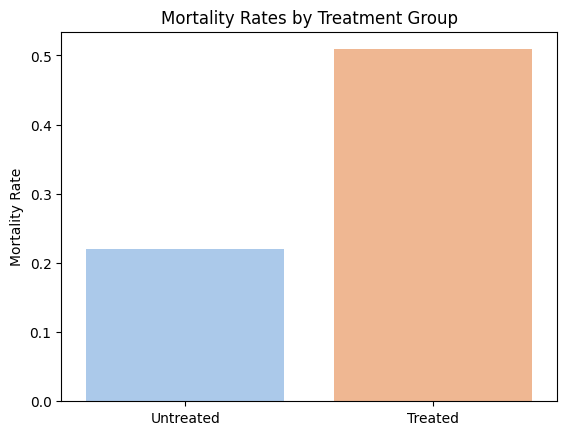

In [47]:
# Mortality rates for treated vs. untreated
mortality_by_treatment = time_agg.groupby('Treatment')['Mortality'].mean()
print("Mortality Rates by Treatment:")
print(mortality_by_treatment)

# Barplot of mortality rates
sns.barplot(x=['Untreated', 'Treated'], y=mortality_by_treatment.values, palette='pastel')
plt.title('Mortality Rates by Treatment Group')
plt.ylabel('Mortality Rate')
plt.show()


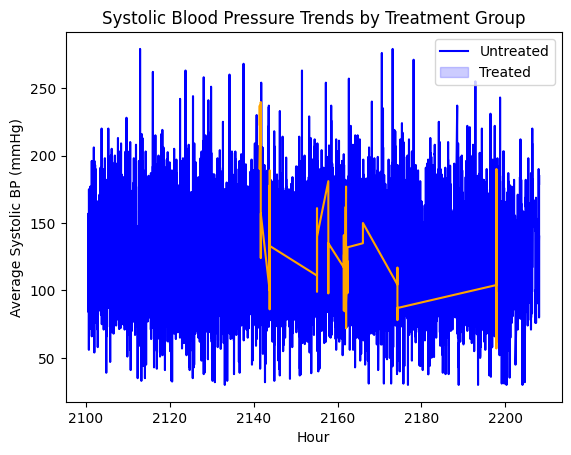

In [37]:
# Systolic BP trends by treatment over time
bp_trends = time_agg.groupby(['Hour', 'Treatment'])['Avg_Systolic_BP'].mean().reset_index()

# Lineplot for systolic BP trends
sns.lineplot(data=bp_trends, x='Hour', y='Avg_Systolic_BP', hue='Treatment', palette=['blue', 'orange'])
plt.title('Systolic Blood Pressure Trends by Treatment Group')
plt.ylabel('Average Systolic BP (mmHg)')
plt.xlabel('Hour')
plt.legend(labels=['Untreated', 'Treated'])
plt.show()


In [48]:
# Define the outcome and treatment variables
outcome = 'Mortality'  # Replace with the actual column name for outcome
treatment = 'Treatment'  # Replace with the actual column name for treatment

# Separate the treated and untreated groups
treated = time_agg[time_agg[treatment] == 1]
untreated = time_agg[time_agg[treatment] == 0]

# Check the sizes of both groups
print(f"Treated group size: {len(treated)}")
print(f"Untreated group size: {len(untreated)}")

# Undersample the untreated group to match the size of the treated group
undersampled_untreated = untreated.sample(n=len(treated), random_state=42)

# Combine the treated group and the undersampled untreated group
balanced_data = pd.concat([treated, undersampled_untreated])

# Shuffle the combined dataset
balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new group sizes
print(f"Balanced dataset size: {len(balanced_data)}")
print(f"New treated group size: {len(balanced_data[balanced_data[treatment] == 1])}")
print(f"New untreated group size: {len(balanced_data[balanced_data[treatment] == 0])}")

valid_values = [0, 1]
balanced_data = balanced_data[balanced_data[outcome].isin(valid_values)]

# Save the balanced dataset if needed
balanced_data.to_csv('balanced_time_agg.csv', index=False)

print("Balanced dataset saved as 'balanced_time_agg.csv'")


Treated group size: 1185
Untreated group size: 217215
Balanced dataset size: 2370
New treated group size: 1185
New untreated group size: 1185
Balanced dataset saved as 'balanced_time_agg.csv'
